In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import pandas as pd
import numpy as np
from numpy import load
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from itertools import chain

from projectwind.data import get_data

# LSTM_data.py

In [ ]:
data = get_data(25)

In [ ]:
save = data.copy()

## Quick check on number of NaN over the period

In [ ]:
# Count number of na
isna_df = data[0].isna().sum(axis=1) / len(data[0].columns)

# Resample on daily basis
daily_data = isna_df.resample('D').sum() / 6 # divide by # periods to get ~ 24hr % missing values

# Graph output
fig, ax = plt.subplots(figsize=(20,5))
plt.bar(x=daily_data.index, height=daily_data.values);

In [ ]:
# Good to see there are less missing values towards end of data 
# (meaning test and validation sets should be of better quality than train set)

## Data engineering

### Interpolate all NaNs

In [ ]:
from projectwind.LSTM_preproc import clean_LSTM_data

In [ ]:
full_data = clean_LSTM_data(data)

### Create wind speed & direction vectors and misalignment to average wind farm vector

In [ ]:
# Average wind speeds & directions over the wind turbines
wind_speeds = pd.DataFrame()
nacelle_dir = pd.DataFrame()
misalignment = pd.DataFrame()
for idx, WTG_data in enumerate(data):
    wind_speeds[idx] = WTG_data['Wind Speed']
    nacelle_dir[idx] = WTG_data['Nacelle Orientation']
    misalignment[idx] = WTG_data['Misalignment']

In [ ]:
for idx in misalignment:
    misalignment[idx] = misalignment[idx].apply(lambda x: x if x <=180 else (360 - x)*-1)

In [ ]:
wind_dir = pd.DataFrame()
for idx in misalignment:
    wind_dir[idx] = nacelle_dir[idx] - misalignment[idx]

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(len(nacelle_dir.columns)):
    row, col = i//5, i%5
    axes[row,col].hist2d(wind_dir[i], wind_speeds[i], bins=(50, 50), vmax=400)
    plt.xlabel('Wind Direction [deg]')
    plt.ylabel('Wind Velocity [m/s]');
plt.tight_layout()

In [ ]:
wind_X_vector = pd.DataFrame()
wind_Y_vector = pd.DataFrame()
for idx in wind_dir:
    wind_dir[idx] = wind_dir[idx] * np.pi / 180 # convert to radians
    wind_X_vector[idx] = wind_speeds[idx] * np.cos(wind_dir[idx])  # get X vector
    wind_Y_vector[idx] = wind_speeds[idx] * np.sin(wind_dir[idx])  # get Y vector
    wind_X_vector[idx] = wind_speeds[idx] * np.cos(wind_dir[idx])  # get X vector
    wind_Y_vector[idx] = wind_speeds[idx] * np.sin(wind_dir[idx])  # get Y vector

In [ ]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i in range(len(nacelle_dir.columns)):
    row, col = i//5, i%5
    axes[row,col].hist2d(wind_X_vector[i], wind_Y_vector[i], bins=(50, 50), vmax=400)
    plt.xlabel('Wind X [m/s]')
    plt.ylabel('Wind Y [m/s]');
plt.tight_layout()

In [ ]:
for idx, WTG_data in enumerate(data):
    WTG_data['WTG_wind_X'] = wind_X_vector[idx]
    WTG_data['WTG_wind_Y'] = wind_Y_vector[idx]
#     WTG_data['Misalign_wind_X'] = average['X_vector'] - wind_X_vector[idx] # Creates data leakage!
#     WTG_data['Misalign_wind_Y'] = average['Y_vector'] - wind_Y_vector[idx] # Creates data leakage!
    WTG_data.drop(columns=['Misalignment','Nacelle Orientation'], inplace=True)

### Power vs. Rotor Speed check

In [ ]:
temp = data[19].loc['2020-03-05':'2020-03-06']

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
sns.lineplot(x=temp.index, y=temp['Power']/150)
sns.lineplot(x=temp.index, y=temp['Rotor Speed'])
sns.lineplot(x=temp.index, y=temp['Wind Speed'])
fig.legend(['Power','Rotor Speed', 'Wind Speed']);

### Sine/Cosine Time

In [ ]:
df = pd.DataFrame(index=data[0].index)
timestamp_s = data[0].index.map(pd.Timestamp.timestamp)

day = 24*60*60

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

In [ ]:
plt.plot(df.iloc[0:792,0])
plt.plot(df.iloc[0:792,1]);

In [ ]:
for WTG_data in data:
    WTG_data['Day sin'] = df['Day sin']
    WTG_data['Day cos'] = df['Day cos']

## Split the data

In [ ]:
df = data[0]
df.head()

In [ ]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [ ]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [ ]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing

In [ ]:
import tensorflow as tf

In [ ]:
df.head()

### Example

In [ ]:
data[2]

In [ ]:
df.columns

In [ ]:
w1 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=df.columns)
w1

In [ ]:
w2 = WindowGenerator(input_width=24*5*6, label_width=12*6, shift=12*6,
                     label_columns=['Power'])
w2

In [ ]:
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

In [ ]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

In [ ]:
for i in w2.train.take(25):
    print(i)

In [ ]:
for example_inputs, example_labels in w2.train.take(100):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

In [ ]:
dataset = w2.train.take(1)

In [ ]:
for sequence in dataset:
    sequence.plot()

### Adaptation

In [ ]:
from projectwind.LSTM_data import WindowGenerator, get_LSTM_data, define_window

In [ ]:
train_df, val_df, test_df = get_LSTM_data(2)

In [ ]:
# Create window
n_steps_in =  24 * 6     # 24hrs x 6 periods of 10min
n_steps_out = 12 * 6    # 12hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df[0], val_df[0], test_df[0])

In [ ]:
def make_dataset(data):
    X_datasets = []
    y_datasets = []
    
    for WTG_data in data:
        
        # Find sequences according to window size of X and y
        WTG_data = np.array(WTG_data, dtype=np.float32)
        WTG_sequences = tf.keras.utils.timeseries_dataset_from_array(data=WTG_data,
                                                                    targets=None,
                                                                    sequence_length=window.total_window_size,
                                                                    sampling_rate=1,
                                                                    sequence_stride=window.total_window_size,
                                                                    shuffle=False,
                                                                    batch_size=32)
        # Split X and y according to window size
        WTG_sequences = WTG_sequences.map(window.split_window)
        
        # Transfer from tensor to numpy array to save under .NPY format
        X_datasets.append(chain.from_iterable([X.numpy() for X, y in WTG_sequences]))
        y_datasets.append(chain.from_iterable([y.numpy() for X, y in WTG_sequences]))
        
    # Aggregate WTGs batches into same array
    X_array = np.array(list(chain.from_iterable(X_datasets)))
    y_array = np.array(list(chain.from_iterable(y_datasets)))
    
    #X_array, y_array = shuffle_sequences(X_array, y_array)
        
    return X_array, y_array

In [ ]:
# Make datasets
X_train, y_train = make_dataset(train_df)
X_val, y_val = make_dataset(val_df)
X_test, y_test = make_dataset(test_df)

In [ ]:
# Verify dataset shapes
print(f"Train set shape:  X: {X_train.shape}, Y: {y_train.shape}")
print(f"Val set shape:    X: {X_val.shape},  Y: {y_val.shape}")
print(f"Test set shape:   X: {X_test.shape},  Y: {y_test.shape}")

In [ ]:
def shuffle_sequences(X, y, seed=42):
    np.random.seed(seed)
    np.random.shuffle(X)
    np.random.seed(seed)
    np.random.shuffle(y)
    return X, y

In [ ]:
X_train, y_train = shuffle_sequences(X_train, y_train, seed=1)
X_val, y_val = shuffle_sequences(X_val, y_val, seed=2)
X_test, y_test = shuffle_sequences(X_test, y_test, seed=3)

In [ ]:
# Verify dataset shapes
print(f"Train set shape:  X: {X_train.shape}, Y: {y_train.shape}")
print(f"Val set shape:    X: {X_val.shape},  Y: {y_val.shape}")
print(f"Test set shape:   X: {X_test.shape},  Y: {y_test.shape}")

In [ ]:
sequence_name = f"{window.input_width // 6}-{window.label_width//6}"
np.save(f'./projectwind/data/LSTM_sequence_X_train_{sequence_name}.npy', np.asanyarray(X_train, dtype=object))
np.save(f'./projectwind/data/LSTM_sequence_y_train_{sequence_name}.npy', np.asanyarray(y_train, dtype=object))
np.save(f'./projectwind/data/LSTM_sequence_X_val_{sequence_name}.npy', np.asanyarray(X_val, dtype=object))
np.save(f'./projectwind/data/LSTM_sequence_y_val_{sequence_name}.npy', np.asanyarray(y_val, dtype=object))
np.save(f'./projectwind/data/LSTM_sequence_X_test_{sequence_name}.npy', np.asanyarray(X_test, dtype=object))
np.save(f'./projectwind/data/LSTM_sequence_y_test_{sequence_name}.npy', np.asanyarray(y_test, dtype=object))

In [ ]:
train_ds = np.load(f'./projectwind/data/LSTM_sequence_train_datasets.npy', allow_pickle=True)

In [ ]:
len(train_ds)

In [ ]:
for inputs, labels in train_ds:
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

### Test of python file

In [ ]:
from projectwind.LSTM_data import WindowGenerator, get_LSTM_data, define_window

In [ ]:
train_df, val_df, test_df = get_LSTM_data(2)

In [ ]:
len(train_df[0])

In [ ]:
n_steps_in =  24 * 6     # 24hrs x 6 periods of 10min
n_steps_out = 12 * 6    # 12hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df[0], val_df[0], test_df[0])

In [ ]:
for inputs, labels in window.train.take(1):
    print(f'Inputs shape (batch, time, features): {inputs.shape}')
    print(f'Labels shape (batch, time, features): {labels.shape}')

# LSTM_model.py

## Prep Dataset

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
from projectwind.LSTM_data import get_LSTM_data, define_window, load_datasets

In [ ]:
train_df, val_df, test_df = get_LSTM_data(2)

In [ ]:
n_steps_in = 5 * 24 * 6     # 5 day x 24hrs x 6 periods of 10min
n_steps_out = 12 * 6    # 12hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df, val_df, test_df)

In [ ]:
X_train, y_train = window.train
X_val, y_val = window.val
X_test, y_test = window.test

In [ ]:
train_ds = window.train
val_ds = window.val
test_ds = window.test

In [ ]:
train_ds

In [ ]:
# Verify dataset shapes
print(f"Train set shape:  X: {X_train.shape},  Y: {y_train.shape}")
print(f"Val set shape:    X: {X_val.shape},  Y: {y_val.shape}")
print(f"Test set shape:   X: {X_test.shape},  Y: {y_test.shape}")

## Create & Save 48h - 3hr dataset

In [ ]:
from projectwind.LSTM_data import get_LSTM_data, define_window, load_datasets

In [ ]:
train_df, val_df, test_df = get_LSTM_data()

In [ ]:
n_steps_in = 48 * 6     # 5 day x 24hrs x 6 periods of 10min
n_steps_out = 3 * 6    # 12hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df, val_df, test_df)

In [ ]:
X_train, y_train = window.train
X_val, y_val = window.val
X_test, y_test = window.test

In [ ]:
# Verify dataset shapes
print(f"Train set shape:  X: {X_train.shape},  Y: {y_train.shape}")
print(f"Val set shape:    X: {X_val.shape},  Y: {y_val.shape}")
print(f"Test set shape:   X: {X_test.shape},  Y: {y_test.shape}")

In [ ]:
window.save_datasets

## Basic LSTM_model

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

multi_val_performance = multi_lstm_model.evaluate(window.val)
multi_performance = multi_lstm_model.evaluate(window.test, verbose=0)
multi_window.plot(multi_lstm_model)


## LSTM feedback_model 

In [ ]:
class FeedBack(tf.keras.Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        # First layer
        self.lstm_cell = tf.keras.layers.LSTMCell(units) 
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True) #Wrap the LSTMCell in an RNN to simplify the `warmup` method.
        # Second layer
        self.lstm_cell = tf.keras.layers.LSTMCell(units)
        self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
        # Output layer
        self.dense = tf.keras.layers.Dense(num_features)

    def warmup(self, inputs):
        # inputs.shape => (batch, time, features)
        # x.shape => (batch, lstm_units)
        x, *state = self.lstm_rnn(inputs)

        # predictions.shape => (batch, features)
        prediction = self.dense(x)
        return prediction, state
    
    def call(self, inputs, training=None):
        # Use a TensorArray to capture dynamically unrolled outputs.
        predictions = []

        # Initialize the LSTM state.
        prediction, state = self.warmup(inputs)

        # Insert the first prediction.
        predictions.append(prediction)

        # Run the rest of the prediction steps.
        for n in range(1, self.out_steps):
            # Use the last prediction as input.
            x = prediction
            # Execute one lstm step.
            x, state = self.lstm_cell(x, states=state,
                                      training=training)
            # Convert the lstm output to a prediction.
            prediction = self.dense(x)
            # Add the prediction to the output.
            predictions.append(prediction)

        # predictions.shape => (time, batch, features)
        predictions = tf.stack(predictions)
        # predictions.shape => (batch, time, features)
        predictions = tf.transpose(predictions, [1, 0, 2])
        return predictions

    def compile_and_fit(model, window, patience=2):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

        model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.MeanAbsoluteError()])

        history = model.fit(window.train, epochs=MAX_EPOCHS,
                          validation_data=window.val,
                          callbacks=[early_stopping])
        return history

In [ ]:
for inputs, labels in window.train.take(1):
    num_features = inputs.shape[2]
    n_steps_in = inputs.shape[1]
    n_steps_out = labels.shape[1]

In [ ]:
feedback_model = FeedBack(units=32, out_steps=n_steps_out)

In [ ]:
prediction, state = feedback_model.warmup(window.example[0])
prediction.shape

In [ ]:
feedback_model(window.example[0])

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(window.example[0]).shape)

In [ ]:
MAX_EPOCHS = 20
history = compile_and_fit(feedback_model, window)

In [ ]:
feedback_model.predict(X_test).shape

In [ ]:
val_performance = feedback_model.evaluate(window.val)
test_performance = feedback_model.evaluate(window.test, verbose=0)
window.plot(feedback_model)

## Revising Window_Split to include forecast

In [17]:
%reload_ext autoreload
%autoreload 2

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from itertools import chain

from projectwind.LSTM_weather_forecast import get_LSTM_data, WindowGenerator

In [154]:
train_df, val_df, test_df = get_LSTM_data(2)

### Fetching 2xWTG data ###
### Loaded 2x WTG data ###
### Fetching Forecast from API ###
### Loaded Forecast from API ###
### Preparing datasets ###
### Preparing datasets ###


In [155]:
temp = train_df[0]
temp.head()

,Power,Rotor Speed,Wind Speed,Blade Pitch,Nacelle_X,Nacelle_Y,Wind_X,Wind_Y,Day sin,Day cos,windSpeed_API,windGust_API,Wind_API_X,Wind_API_Y,WindGust_API_X,WindGust_API_Y
2019-05-05 00:00:00,0.788089,0.960957,0.589641,0.004744,0.235022,0.924092,0.273602,0.775695,0.535798,1.000000,0.310611,0.254451,0.529765,0.535515,0.518356,0.466363
2019-05-05 01:00:00,0.751486,0.946565,0.578246,0.005489,0.235022,0.924092,0.278683,0.770760,0.639253,0.979425,0.310611,0.254451,0.545802,0.533390,0.532983,0.464551
2019-05-05 02:00:00,0.825391,0.967641,0.596685,0.009715,0.235022,0.924092,0.275904,0.781553,0.752295,0.929587,0.310611,0.254451,0.564287,0.530479,0.549844,0.462069
2019-05-05 03:00:00,0.902709,0.985970,0.622553,0.013133,0.235022,0.924092,0.269588,0.795470,0.854159,0.850531,0.330463,0.268003,0.589616,0.540286,0.571774,0.468552
2019-05-05 04:00:00,0.893590,0.985891,0.610628,0.012491,0.235022,0.924092,0.279012,0.792330,0.933248,0.747326,0.340185,0.274640,0.587412,0.548042,0.569359,0.474211


In [127]:
import matplotlib.pyplot as plt
import seaborn as sns

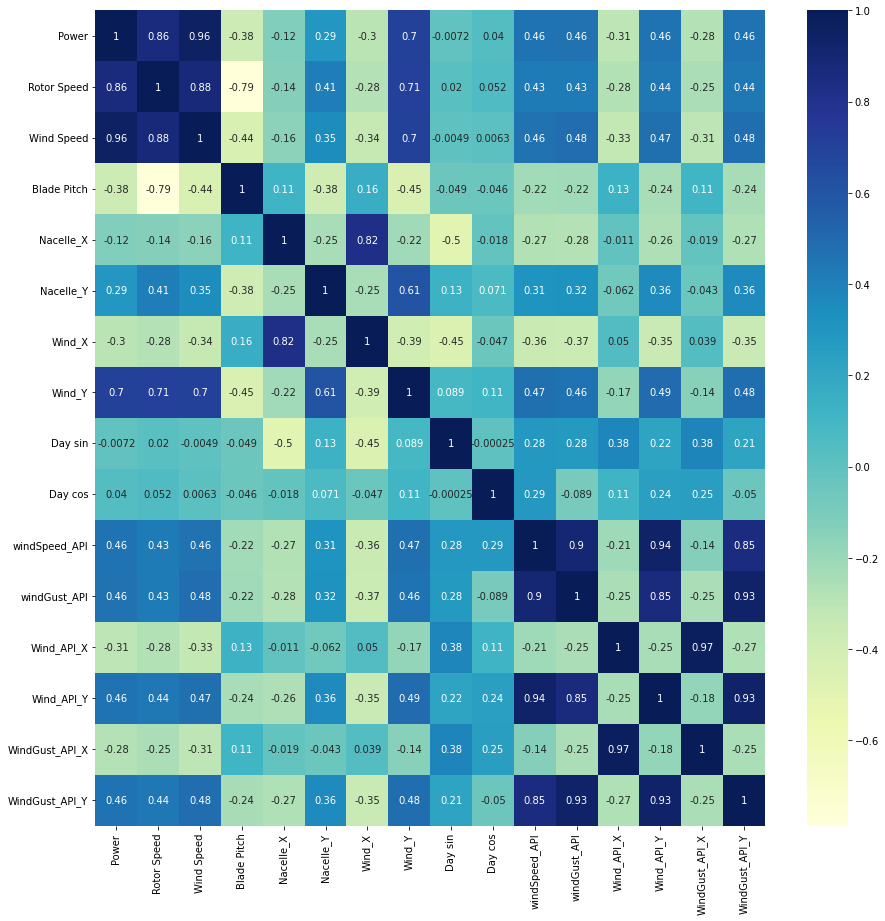

In [128]:
# plotting correlation heatmap
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(axes=ax, data=temp.corr(), cmap="YlGnBu", annot=True);

In [142]:
# Scale datasets
scaling_data = pd.DataFrame(index=['min','max'], columns=train_df[0].columns, data=0)
for WTG_data in train_df:
    for col in WTG_data:
        temp_min = np.min([scaling_data.loc['min', col], WTG_data[col].min(axis=0)])
        temp_max = np.max([scaling_data.loc['max', col], WTG_data[col].max(axis=0)])
        scaling_data.loc['min', col] = temp_min
        scaling_data.loc['max', col] = temp_max
print(scaling_data)

           Power  Rotor Speed  Wind Speed  Blade Pitch  Nacelle_X  Nacelle_Y  \
min   -12.596452     0.000000    0.000000    -0.957726  -0.999846  -0.999936   
max  2146.082825    13.191391   16.036838    87.038147   0.999657   0.999848   

        Wind_X     Wind_Y   Day sin   Day cos  windSpeed_API  windGust_API  \
min -11.611416 -13.836414 -0.989023 -0.989023       0.000000      0.000000   
max  12.585545  14.354097  0.989025  0.995207       8.942944     13.100082   

     Wind_API_X  Wind_API_Y  WindGust_API_X  WindGust_API_Y  
min   -3.686528   -4.023742       -4.787684       -5.003615  
max    4.182779    8.598346        5.565267       12.764328  


In [143]:
# Apply scaling to all three datasets
column_names = train_df[0].columns
for WTGs in range(len(train_df)):
    for col in column_names:
        col_min = scaling_data.loc['min',col]
        col_max = scaling_data.loc['max',col]
        # Scale columns of each dataset
        train_df[WTGs][col] = train_df[WTGs][col].apply(lambda x: (x - col_min) / (col_max - col_min))
        val_df[WTGs][col] = val_df[WTGs][col].apply(lambda x: (x - col_min) / (col_max - col_min))
        test_df[WTGs][col] = test_df[WTGs][col].apply(lambda x: (x - col_min) / (col_max - col_min))

In [144]:
test_df[0]

,Power,Rotor Speed,Wind Speed,Blade Pitch,Nacelle_X,Nacelle_Y,Wind_X,Wind_Y,Day sin,Day cos,windSpeed_API,windGust_API,Wind_API_X,Wind_API_Y,WindGust_API_X,WindGust_API_Y
2021-06-21 22:00:00,0.928301,0.978200,0.693117,0.070077,0.293165,0.953229,0.300807,0.849706,0.250311,0.930284,0.471322,0.379761,0.272949,0.629652,0.286979,0.542241
2021-06-21 23:00:00,0.928016,0.985984,0.669141,0.043967,0.289281,0.953226,0.291373,0.834591,0.370938,0.979992,0.533246,0.440438,0.264135,0.674406,0.274657,0.587291
2021-06-22 00:00:00,0.879148,0.974972,0.631494,0.026794,0.288765,0.953225,0.304041,0.816680,0.500359,0.996883,0.615180,0.503661,0.247762,0.732325,0.261207,0.633923
2021-06-22 01:00:00,0.777104,0.953690,0.594868,0.009473,0.288696,0.953225,0.308776,0.795499,0.629756,0.979806,0.647356,0.553680,0.240512,0.754867,0.245379,0.669737
2021-06-22 02:00:00,0.882275,0.980369,0.645369,0.017597,0.288687,0.953225,0.279317,0.814910,0.750311,0.929925,0.671467,0.610642,0.224374,0.769516,0.215092,0.708118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-09-16 07:00:00,0.230852,0.677272,0.370887,0.011018,0.174541,0.875726,0.321334,0.648477,0.982869,0.369089,0.294424,0.361776,0.282174,0.491887,0.207015,0.502780
2021-09-16 08:00:00,0.078704,0.610845,0.256855,0.033021,0.197874,0.896345,0.377691,0.606687,0.932832,0.248910,0.281525,0.360646,0.292624,0.485390,0.211576,0.503690
2021-09-16 09:00:00,0.081033,0.614968,0.268898,0.030818,0.222108,0.913771,0.381658,0.617490,0.853298,0.145737,0.259975,0.360496,0.307347,0.473175,0.213699,0.504396
2021-09-16 10:00:00,0.239357,0.695290,0.366556,0.016409,0.196680,0.896145,0.334016,0.656403,0.749688,0.066599,0.269852,0.374018,0.304404,0.480309,0.209188,0.514549


In [71]:
n_steps_in = 48   # hrs 
n_steps_out = 3   # hrs

window = WindowGenerator(input_width=n_steps_in, label_width=n_steps_out, shift=n_steps_out,
                         train_df=train_df, val_df=val_df, test_df=test_df,
                         forecast_columns=['windSpeed_API','windGust_API',
                                           'Wind_API_X','Wind_API_Y', 
                                           'WindGust_API_X', 'WindGust_API_Y'],
                         label_columns=['Power'])

In [72]:
X_train, X_fc_train, y_train, = window.make_dataset(train_df)

In [73]:
X_train.shape, X_fc_train.shape, y_train.shape

((570, 48, 16), (570, 3, 6), (570, 3, 1))

In [74]:
X_val, X_fc_val, y_val, = window.make_dataset(val_df)

In [75]:
X_val.shape, X_fc_val.shape, y_val.shape

((162, 48, 16), (162, 3, 6), (162, 3, 1))

In [76]:
X_test, X_fc_test, y_test, = window.make_dataset(test_df)

In [77]:
X_test.shape, X_fc_test.shape, y_test.shape

((80, 48, 16), (80, 3, 6), (80, 3, 1))

## LSTM model concat with weather forecast

In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from projectwind.data import get_data
from projectwind.LSTM_weather_forecast import get_LSTM_data, define_window, load_datasets

In [ ]:
train_df, val_df, test_df = get_LSTM_data(1)

In [ ]:
n_steps_in = 48 * 6     # 48hrs x 6 periods of 10min
n_steps_out = 3 * 6    #  3hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df, val_df, test_df, 'Power')

In [ ]:
# Split weather data from main dfs
train_wf = list()
for df in train_df:
    train_wf.append(df[['Wind Speed','Wind_X','Wind_Y']].copy())
    df.drop(['Wind Speed','Wind_X', 'Wind_Y'], axis=1, inplace=True)

val_wf = list()
for df in val_df:
    val_wf.append(df[['Wind Speed','Wind_X','Wind_Y']].copy())
    df.drop(['Wind Speed','Wind_X', 'Wind_Y'], axis=1, inplace=True)
    
test_wf = list()
for df in test_df:
    test_wf.append(df[['Wind Speed','Wind_X','Wind_Y']].copy())
    df.drop(['Wind Speed','Wind_X', 'Wind_Y'], axis=1, inplace=True)

In [ ]:
n_steps_in = 48 * 6     # 48hrs x 6 periods of 10min
n_steps_out = 3 * 6    #  3hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df, val_df, test_df, 'Power')

In [ ]:
X_train, y_train = window.train
X_val, y_val = window.val
X_test, y_test = window.test

In [ ]:
n_steps_in = 48 * 6     # 48hrs x 6 periods of 10min
n_steps_out = 3 * 6    #  3hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_wf, val_wf, test_wf, 'Wind Speed')

In [ ]:
X_train_wf, y_train_wf = window.train
X_val_wf, y_val_wf = window.val
X_test_wf, y_test_wf = window.test

In [ ]:
def performance_model():
    input_perf = tf.keras.layers.Input(shape=(n_steps_in, X_train.shape[2]))
    x_state = tf.keras.layers.LSTM(32, return_sequences=True)(input_perf)
    x_state = tf.keras.layers.LSTM(32, return_sequences=True)(x_state)
    x = tf.keras.layers.LSTM(32, return_sequences=False)(x_state)
    output_perf = tf.keras.layers.Dense(n_steps_out)(x)
    
    model = tf.keras.models.Model(inputs=input_perf, outputs=output_perf)
    return model

In [ ]:
perf_model = performance_model()
perf_model.summary()

In [ ]:
def forecast_model():
    input_fc = tf.keras.layers.Input(shape=(18,))  # Will only use y_forecast
    x = tf.keras.layers.Dense(32, activation='relu')(input_fc)
    output_fc = tf.keras.layers.Dense(18, activation="relu")(x)
    
    model = tf.keras.models.Model(inputs=input_fc, outputs=output_fc)
    return model

In [ ]:
model_fc = forecast_model()
model_fc.summary()

In [ ]:
# Combined model
model_perf = performance_model() # comment-out to keep pre-trained weights not to start from scratch
input_perf = model_perf.input
output_perf = model_perf.output

model_fc = forecast_model() # comment-out to keep pre-trained weights not to start from scratch
input_fc = model_fc.input
output_fc = model_fc.output

In [ ]:
input_perf, output_perf

In [ ]:
input_fc, output_fc

In [ ]:
# Combine the two streams of data
inputs = [input_perf, input_fc]

combined = tf.keras.layers.concatenate([output_perf, output_fc])

x = tf.keras.layers.Dense(n_steps_out, activation="relu")(combined)

outputs = tf.keras.layers.Dense(n_steps_out, activation="linear")(x)

model_combined = tf.keras.models.Model(inputs=inputs, outputs=outputs)

In [ ]:
model_combined.summary()

In [ ]:
X_train.shape, y_train_wf2.shape, y_train.shape

In [ ]:
y_train_wf2 = y_train_wf.reshape((289,18))

In [ ]:
X_val.shape, y_val_wf.shape, y_val.shape

In [ ]:
model_fc.compile(optimizer='adam', loss='huber', metrics=["mae"])
model_perf.compile(optimizer='adam', loss='huber', metrics=["mae"])
model_combined.compile(optimizer='adam', loss='huber', metrics=["mae"])

In [ ]:
# Huber
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2, restore_best_weights=True)

history = model_combined.fit(x=[X_train, y_train_wf],y=y_train,
                            epochs=10)

### Combined Model _v2

In [13]:
def hybrid_model():
    input_perf = tf.keras.layers.Input(shape=(n_steps_in, X_train.shape[2]))
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(input_perf)
    x_seq = tf.keras.layers.LSTM(32, return_sequences=True)(x_seq)
    x_perf = tf.keras.layers.LSTM(32, return_sequences=False)(x_seq)
    #x_perf = tf.keras.layers.Reshape((32*X_train.shape[1],))(x_perf)
    input_fc = tf.keras.layers.Input(shape=(18,))
    x = tf.keras.layers.Dense(32, activation='relu')(input_fc)
    x_fc = tf.keras.layers.Dense(18, activation="relu")(x)
    
    combined = tf.keras.layers.concatenate([x_perf, x_fc])
    x = tf.keras.layers.Dense(64, activation="relu")(combined)
    outputs = tf.keras.layers.Dense(n_steps_out, activation="linear")(x)
    
    model = tf.keras.models.Model(inputs=[input_perf, input_fc], outputs=outputs)
    return model

In [14]:
h_model=hybrid_model()
h_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 13)]    0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 288, 32)      5888        ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 18)]         0           []                               
                                                                                                  
 lstm_1 (LSTM)                  (None, 288, 32)      8320        ['lstm[0][0]']                   
                                                                                              

In [ ]:
h_model.compile(optimizer='adam', loss='huber', metrics=["mae"])

In [ ]:
# Huber
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2, restore_best_weights=True)

history = h_model.fit(x=[X_train, y_train_wf],y=y_train,
                            epochs=10)

# Tutorial LSTM_Model

In [ ]:
from projectwind.LSTM_data import WindowGenerator, get_LSTM_data, define_window

In [ ]:
train_df, val_df, test_df = get_LSTM_data(2)

In [ ]:
# Create window
n_steps_in =  48 * 6     # 48hrs x 6 periods of 10min
n_steps_out = 3 * 6    # 3hours x 6 periods of 10min
window = define_window(n_steps_in, n_steps_out, train_df, val_df, test_df)

In [ ]:
# Make datasets
X_train, y_train = window.train
X_val, y_val = window.val
X_test, y_test = window.test

In [ ]:
X_ex, y_ex = window.example

In [ ]:
multi_lstm_model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(n_steps_in, len(window.column_indices))),
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(n_steps_out),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([n_steps_out, 1])
])

In [ ]:
def compile_and_fit(model, window, patience=2):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

    model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

    history = model.fit(X_train, y_train, 
                        epochs=5,
                        validation_data=(X_val, y_val),
                        callbacks=[early_stopping])
    return history

In [ ]:
history = compile_and_fit(multi_lstm_model, window)

In [ ]:
val_performance = multi_lstm_model.evaluate(X_val, y_val)
test_performance = multi_lstm_model.evaluate(X_test, y_test, verbose=0)

In [ ]:
window.plot(multi_lstm_model)

In [ ]:
from projectwind.trainer import plot_loss

In [ ]:
plot_loss(history)

# OLD - LSTM_data_preproc

In [ ]:
raw_data = get_data(25)

In [ ]:
raw_data[13]

In [ ]:
data = clean_timesteps(raw_data)
data = clean_LSTM_data(data)

## clean_LSTM_data

In [ ]:
temp_data = data[0]

In [ ]:
index_with_nan = temp_data[temp_data.isna().any(axis=1) == True].index

In [ ]:
temp_data.loc[index_with_nan]

In [ ]:
temp_data.loc['2019-05-06 09:30':'2019-05-06 15:00']

In [ ]:
temp_data.loc['2019-05-06 09:30':'2019-05-06 15:00']

In [ ]:
for WTG_data in data:
    print(WTG_data.isna().sum().sum())
    WTG_data.interpolate(axis=0, inplace=True)
    print(WTG_data.isna().sum().sum())

##  split_LSTM_data

In [ ]:
temp = data[0]

In [ ]:
len(data[0])

In [ ]:
seq_len = int(24 * 6 * 5.5)
seq_len

In [ ]:
# Find number of seq possible
seq_num = len(data[0]) // (720+72) # per turbine
seq_num

In [ ]:
test_seq_len = int(0.2 * seq_num) # last 20% indices will belong to test set
val_seq_len  = int(0.2 * seq_num) # 2nd last 20% indices will belong to val set
test_seq_len, val_seq_len

In [ ]:
test_seq_start = seq_num - test_seq_len
val_seq_start = seq_num - test_seq_len - val_seq_len
0, val_seq_start, test_seq_start, 160

In [ ]:
test_idx_start = test_seq_start * seq_len
val_idx_start = val_seq_start * seq_len
val_idx_start, test_idx_start

In [ ]:
# Aggregated
test_idx_start = int((seq_num - (seq_num * 0.2)) * seq_len)
val_idx_start = int((seq_num - (seq_num * 0.4)) * seq_len)
val_idx_start, test_idx_start

In [ ]:
# Aggregated
seq_len = int(24 * 6 * 5.5)
seq_num = len(data[0]) // (720+72) # per turbine
test_idx_start = int(seq_num * (0.8 * seq_len))
val_idx_start = int(seq_num * (0.6 * seq_len))
val_idx_start, test_idx_start

In [ ]:
temp.iloc[val_idx_start:test_idx_start]

In [ ]:
# Test function
from projectwind.LSTM_preproc import split_train_val_test_split

In [ ]:
train, val, test = split_train_val_test_split(data, 5.5)

In [ ]:
train[0]

## get_sequence

In [ ]:
from projectwind.LSTM_preproc import get_sequences

In [ ]:
sequences = get_sequences(train, 5.5)

In [ ]:
sequences

## extract_target_from_sequences

In [ ]:
datasets = {'train':[1,2,3], 'val':[4,5], 'test':[6,7]}

In [ ]:
datasets = dict(train=[1,2,3], val=[4,5], test=[6,7])

In [ ]:
datasets

In [ ]:
for name, data in datasets.items():
    print(name)

In [ ]:
from projectwind.LSTM_preproc import extract_target_from_sequences

In [ ]:
sequences[0].shape[0]

In [ ]:
X, Y = extract_target_from_sequences(sequences, 0.5)

## init_LSTM_data

In [ ]:
from projectwind.LSTM_preproc import init_LSTM_data

In [ ]:
X_train, y_train, X_val, y_val, X_test, y_test = init_LSTM_data(1, 5.5)

In [ ]:
len(X_train), len(X_val), len(X_test)

# OLD - Trainer_LSTM_model

In [ ]:
train_ds = np.load(f'./projectwind/data/LSTM_sequence_train_datasets.npy', allow_pickle=True)
val_ds = np.load(f'./projectwind/data/LSTM_sequence_val_datasets.npy', allow_pickle=True)
test_ds = np.load(f'./projectwind/data/LSTM_sequence_test_datasets.npy', allow_pickle=True)

In [ ]:
from projectwind.LSTM_model import init_LSTM_model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization

In [ ]:
def init_LSTM_model(n_steps_in, n_steps_out, n_features):

    model = Sequential()
    model.add(BatchNormalization(input_shape=(n_steps_in, n_features)))
    model.add(LSTM(16, activation='tanh', return_sequences=True))
    model.add(LSTM(32, activation='tanh', return_sequences=False))
    model.add(Dense(n_steps_out, activation='linear'))
    model.compile(optimizer='adam', loss='huber', metrics=["mae"])

    return model

In [ ]:
model = init_LSTM_model(n_steps_in=window.input_width, 
                        n_steps_out=window.label_width, 
                        n_features=len(window.column_indices))

In [ ]:
model.summary()

In [ ]:
# Huber
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=2, restore_best_weights=True)

history = model.fit(X_train,y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    callbacks=[es])

In [ ]:
window.plot(model)

In [ ]:
# MAE
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(window.train,
                    validation_data=window.val,
                    epochs=2,
                    callbacks=[es])

In [ ]:
# MSE
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=1, restore_best_weights=True)

history = model.fit(window.train,
                    validation_data=(X_val, y_val),
                    epochs=2,
                    callbacks=[es])

In [ ]:
from projectwind.trainer import plot_loss

In [ ]:
plot_loss(history)

## 